In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics
import sys
from sklearn.model_selection import ParameterGrid

In [2]:
#load data
Seer_data = pd.read_csv('Seer17lgg_20250410.csv')

In [3]:
def set_adjuvant_treatment(row):
    if row['Radiotherapy'] == 'Yes' and row['Chemotherapy'] == 'Yes':
        return 'CRT'
    elif row['Radiotherapy'] == 'Yes' and row['Chemotherapy'] == 'No/Unknown':
        return 'RT'
    elif row['Radiotherapy'] == 'No' and row['Chemotherapy'] == 'Yes':
        return 'CT'
    else:
        return 'None'
Seer_data['AdjuvantTreatment'] = Seer_data.apply(set_adjuvant_treatment, axis=1)

In [4]:
Seer_data = Seer_data.drop(columns=['Radiotherapy', 'Chemotherapy',])
Seer_data = Seer_data.rename(columns={'Times': 'time', 'Status': 'event'})

In [5]:
# impute data 
imputer = SimpleImputer(missing_values=np.nan, strategy='median') 
Seer_data['Size'] = imputer.fit_transform(Seer_data[['Size']])

In [7]:
#OneHotEncoder
encoder = preprocessing.OneHotEncoder()
encoded_columns = encoder.fit_transform(Seer_data[['Surgery','AdjuvantTreatment']])
encoded_df = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out())
features_encoded = Seer_data.drop(columns=['Surgery','AdjuvantTreatment'])
features_encoded = pd.concat([features_encoded, encoded_df], axis=1)
features_encoded['Sex'] = features_encoded['Sex'].map({'Male': 1, 'Female': 0})
features_encoded['Subtype'] = features_encoded['Subtype'].map({'AST(IDH-mutant)': 1, 'OLI(IDH-mutant)': 0})

#Create stratified sampling labels
features_encoded['time_event'] = pd.qcut(features_encoded['time'], q=5).astype(str) + '_' + features_encoded['event'].astype(str)

#Data partitioning
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=666)
for train_index, validation_index in sss.split(features_encoded, features_encoded['time_event']):
    training_data = features_encoded.iloc[train_index]
    validation_data_in = features_encoded.iloc[validation_index]

training_data = training_data.drop('time_event', axis=1)
validation_data_in = validation_data_in.drop('time_event', axis=1)

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index
import random
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from tqdm import tqdm
import warnings

def create_structure(num_layers, input_dim, hyperparameters):
    structure = []
    current_units = input_dim
    for i in range(num_layers):
        layer = {
            "activation": random.choice(hyperparameters['activations']),
            "num_units": random.choice(hyperparameters['units']),
        }
        if layer["activation"] == "ELU":
            layer["alpha"] = 1.0
        structure.append(layer)
    return structure

def evaluate_model(model, X, T, E):
    try:
        c_index = concordance_index(model, X, T, E)
        return c_index
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

def train_and_evaluate_fold(train_data, valid_data, trainCols, structure, params):
    try:
        model = NonLinearCoxPHModel(structure=structure, auto_scaler=True)
        
        train_X = train_data[trainCols]
        train_T = train_data['time']
        train_E = train_data['event']
        
        valid_X = valid_data[trainCols]
        valid_T = valid_data['time']
        valid_E = valid_data['event']
        
        model.fit(train_X, train_T, train_E,
                 lr=params['lr'],
                 num_epochs=params['num_epochs'],
                 dropout=params['dropout'],
                 l2_reg=params['l2_reg'],
                 batch_normalization=params['batch_normalization'])
        
        score = evaluate_model(model, valid_X, valid_T, valid_E)
        return score
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

def findHyperparameterDCPH(train_data, trainCols, RS=42, max_iterations=500, early_stop=20):
    np.random.seed(RS)
    random.seed(RS)
    
    hyperparameters = {
        'activations': ['ReLU', 'LeakyReLU', 'Tanh'],  
        'units': [16, 32, 64],
        'lr': [1e-3, 5e-4, 1e-4],
        'num_epochs': [1000, 2000],
        'dropout': [0.1, 0.2, 0.3],
        'l2_reg': [1e-3, 1e-4],
        'batch_normalization': [True],
        'num_layers': [1, 2]
    }
    
    best_score = -np.inf
    best_params = None
    best_structure = None
    no_improvement_count = 0
    history = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=RS)
    
    for iteration in tqdm(range(max_iterations)):
        current_params = {
            'lr': random.choice(hyperparameters['lr']),
            'num_epochs': random.choice(hyperparameters['num_epochs']),
            'dropout': random.choice(hyperparameters['dropout']),
            'l2_reg': random.choice(hyperparameters['l2_reg']),
            'batch_normalization': random.choice(hyperparameters['batch_normalization']),
            'num_layers': random.choice(hyperparameters['num_layers'])
        }
        
        structure = create_structure(
            current_params['num_layers'],
            len(trainCols),
            hyperparameters
        )
        
        fold_scores = []
        for train_idx, valid_idx in kf.split(train_data):
            train_fold = train_data.iloc[train_idx]
            valid_fold = train_data.iloc[valid_idx]
            
            score = train_and_evaluate_fold(
                train_fold,
                valid_fold,
                trainCols,
                structure,
                current_params
            )
            
            if score is not None:
                fold_scores.append(score)
        
        if fold_scores:
            avg_score = np.mean(fold_scores)
            
            history.append({
                'iteration': iteration,
                'score': avg_score,
                'params': current_params,
                'structure': structure
            })
            
            if avg_score > best_score:
                best_score = avg_score
                best_params = current_params
                best_structure = structure
                no_improvement_count = 0
                print(f"\nNew best model! Score: {best_score:.4f}")
                print(f"Parameters: {best_params}")
                print(f"Structure: {best_structure}")
            else:
                no_improvement_count += 1
        
        if no_improvement_count >= early_stop:
            print("\nEarly stopping triggered")
            break
    
    print("\nSearch completed!")
    print(f"Best score: {best_score:.4f}")
    print(f"Best parameters: {best_params}")
    print(f"Best structure: {best_structure}")
    
    return best_params, best_structure, best_score, history

In [10]:
all_columns = training_data.columns.tolist()
exclude_columns = ['time', 'event']
other_columns = [col for col in all_columns if col not in exclude_columns]
print("Columns excluding 'time' and 'event':")
print(other_columns)

Columns excluding 'time' and 'event':
['Age', 'Sex', 'Size', 'Subtype', 'Surgery_GTR', 'Surgery_PR', 'Surgery_STR', 'AdjuvantTreatment_CRT', 'AdjuvantTreatment_CT', 'AdjuvantTreatment_None', 'AdjuvantTreatment_RT']


In [16]:
#best_params, best_structure, best_score, history = findHyperparameterDCPH(training_data, other_columns)

% Completion: 100%|***********************************************|Loss:  44.36                                      |
% Completion: 100%|***********************************************|Loss:  53.11
% Completion: 100%|***********************************************|Loss:  76.54
% Completion: 100%|***********************************************|Loss:  51.41
% Completion: 100%|***********************************************|Loss:  66.85
% Completion: 100%|***********************************************|Loss:  31.47                                                 |
% Completion: 100%|***********************************************|Loss:  38.86
% Completion: 100%|***********************************************|Loss:  61.30
% Completion: 100%|***********************************************|Loss:  35.68
% Completion: 100%|***********************************************|Loss:  51.50
% Completion: 100%|***********************************************|Loss:  21.87                                

In [25]:
hpDCPH = {
        'structure': [{'activation': 'ReLU', 'num_units': 16}],
        'lr': 0.0001,
        'num_epochs': 5000,
        'dropout': 0.2,
        'l2_reg': 0.0001,
        'batch_normalization': True
}

In [12]:
td = {
            'x': training_data.loc[:, other_columns],
            'e': np.squeeze(training_data[["event"]]),
            't': np.squeeze(training_data[["time"]])
        }

In [13]:
val_in = {
            'x': validation_data_in.loc[:, other_columns],
            'e': np.squeeze(validation_data_in[["event"]]),
            't': np.squeeze(validation_data_in[["time"]])
        }

In [14]:
PUSH_data = pd.read_csv('Validation2_20250410.csv',keep_default_na=False)

encoder = preprocessing.OneHotEncoder()
encoded_columns = encoder.fit_transform(PUSH_data[['Surgery','AdjuvantTreatment']])
encoded_df = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out())
features_encoded = PUSH_data.drop(columns=['Surgery','AdjuvantTreatment'])
features_encoded = pd.concat([features_encoded, encoded_df], axis=1)
features_encoded['Sex'] = features_encoded['Sex'].map({'Male': 1, 'Female': 0})
features_encoded['Subtype'] = features_encoded['Subtype'].map({'AST(IDH-mutant)': 1, 'OLI(IDH-mutant)': 0})

validation_data_out = features_encoded

In [15]:
def align_features(test_data, train_columns):
    missing_cols = set(train_columns) - set(test_data.columns)
    for col in missing_cols:
        test_data[col] = 0  
    
    test_data = test_data[train_columns]
    return test_data

train_columns = training_data.columns
validation_data_out = align_features(validation_data_out, train_columns)

In [16]:
val_out = {
            'x': validation_data_out.loc[:, other_columns],
            'e': np.squeeze(validation_data_out[["event"]]),
            't': np.squeeze(validation_data_out[["time"]])
        }
val_out['t'] = val_out['t'].astype(int)

In [26]:
import pickle
from joblib import dump, load
from pysurvival.utils import save_model

#nncph = NonLinearCoxPHModel(structure = hpDCPH['structure'], auto_scaler = True)
#nncph.fit(td['x'], td['t'], td['e'], verbose=False, lr=hpDCPH['lr'], num_epochs = hpDCPH['num_epochs'], dropout = hpDCPH['dropout'], l2_reg= hpDCPH['l2_reg'], batch_normalization=hpDCPH['batch_normalization'])
#save_model(nncph, "/home/pengfeixu/jupyter_home/SEER17_LGG/DCPHModelFinal.zip")

#with open('/home/pengfeixu/jupyter_home/SEER17_LGG/DCPHModelFinal.pkl', 'wb') as f:
    #pickle.dump(nncph, f)

from pysurvival.utils import load_model
nncph = load_model('/home/pengfeixu/jupyter_home/SEER17_LGG/DCPHModelFinal.zip')

Saving the model to disk as /home/pengfeixu/jupyter_home/SEER17_LGG/DCPHModelFinal.zip


/tmp/ipykernel_327819/3722992320.py:7: FutureWarning: 'pyarrow.serialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  save_model(nncph, "/home/pengfeixu/jupyter_home/SEER17_LGG/DCPHModelFinal.zip")


In [28]:
from pysurvival.utils.metrics import concordance_index
train_c_index = concordance_index(nncph, td['x'], td['t'], td['e'])
val_in_c_index = concordance_index(nncph, val_in['x'], val_in['t'], val_in['e'])
val_out_c_index = concordance_index(nncph, val_out['x'], val_out['t'], val_out['e'])

print('nncph C-index in training : {:.2f}'.format(train_c_index)) 
print('nncph C-index in validation data: {:.2f}'.format(val_in_c_index)) 
print('nncph C-index in validation data: {:.2f}'.format(val_out_c_index)) 

nncph C-index in training : 0.92
nncph C-index in validation data: 0.78
nncph C-index in validation data: 0.88


In [29]:
from pysurvival.utils.metrics import brier_score
def compute_ibs(model, X, T, E, t_max=None, use_mean_point=True):
    # Computing the brier scores
    times, brier_scores = brier_score(model, X, T, E, t_max, use_mean_point)
    # Getting the proper value of t_max
    if t_max is None:
        t_max = max(times)
    else:
        t_max = min(t_max, max(times))

    # Computing the IBS
    ibs_value = np.trapz(brier_scores, times)/t_max 
    return ibs_value

train_ibs = compute_ibs(nncph, td['x'], td['t'], td['e'])
val_in_ibs = compute_ibs(nncph, val_in['x'], val_in['t'], val_in['e'])
val_out_ibs = compute_ibs(nncph, val_out['x'],val_out['t'], val_out['e'])

print('nncph IBS in training : {:.2f}'.format(train_ibs)) 
print('nncph IBS in validation data: {:.2f}'.format(val_in_ibs)) 
print('nncph IBS in validation data: {:.2f}'.format(val_out_ibs)) 

nncph IBS in training : 0.01
nncph IBS in validation data: 0.02
nncph IBS in validation data: 0.01


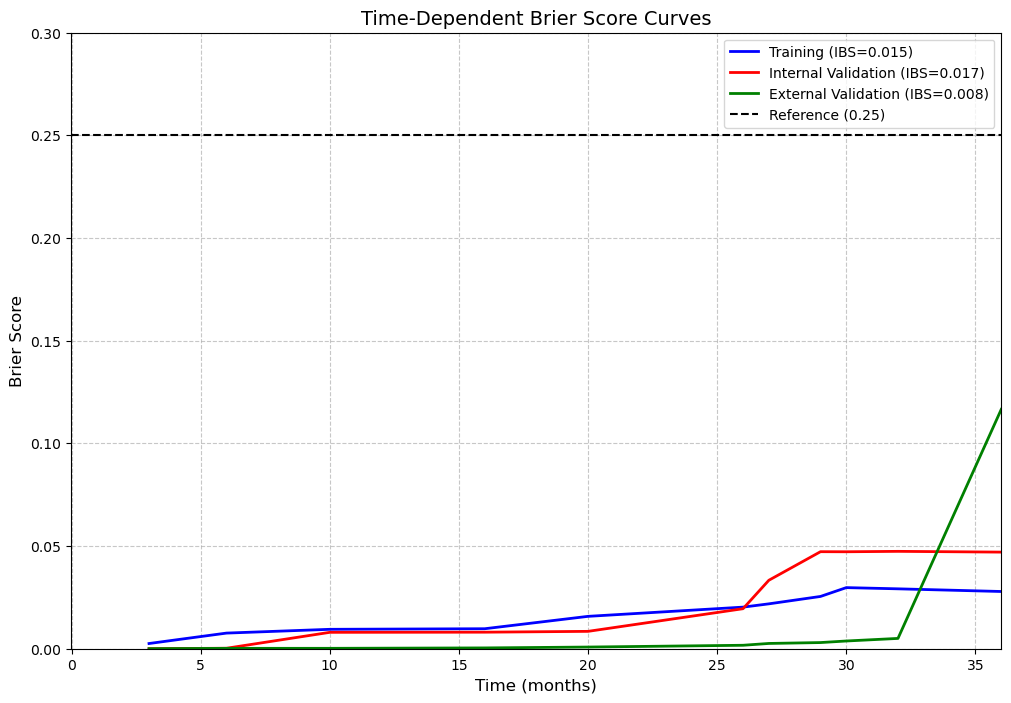

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from pysurvival.utils.metrics import brier_score

def plot_brier_curves(model, datasets, labels, t_max=None, use_mean_point=True, figure_size=(12, 8)):
  
    plt.figure(figsize=figure_size)
    colors = ['blue', 'red', 'green']  
    
    for (name, data), label, color in zip(datasets.items(), labels, colors):
        times, brier_scores = brier_score(model, data['x'], data['t'], data['e'], 
                                        t_max, use_mean_point)
        
        if t_max is None:
            current_t_max = max(times)
        else:
            current_t_max = min(t_max, max(times))
        
        ibs_value = np.trapz(brier_scores, times)/current_t_max
        
        plt.plot(times, brier_scores, color=color, linewidth=2, 
                label=f'{label} (IBS={ibs_value:.3f})')
    
    plt.axhline(y=0.25, ls='--', color='black', label='Reference (0.25)')
    
    plt.xlim(-0.01, max(times))
    plt.ylim(0, 0.3)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.title('Time-Dependent Brier Score Curves', fontsize=14)
    plt.xlabel('Time (months)', fontsize=12)
    plt.ylabel('Brier Score', fontsize=12)
    
    plt.legend(fontsize=10, loc='upper right')
    plt.savefig("brier_curves.pdf", format='pdf', bbox_inches='tight')
    plt.show()

datasets = {
    'train': {'x': td['x'], 't': td['t'], 'e': td['e']},
    'val_in': {'x': val_in['x'], 't': val_in['t'], 'e': val_in['e']},
    'val_out': {'x': val_out['x'], 't': val_out['t'], 'e': val_out['e']}
}

labels = ['Training', 'Internal Validation', 'External Validation']

plot_brier_curves(nncph, datasets, labels)


In [31]:
one_hot_groups = {
    'Surgery': ['Surgery_GTR', 'Surgery_PR', 'Surgery_STR'],
    'AdjuvantTreatment': ['AdjuvantTreatment_CRT', 'AdjuvantTreatment_CT', 'AdjuvantTreatment_None', 'AdjuvantTreatment_RT']
}

def one_hot_to_labels(df, one_hot_groups):
    for label, columns in one_hot_groups.items():
        df[label] = df[columns].idxmax(axis=1)
        df[label] = df[label].str.replace(f'{label}_', '', regex=False)
        df.drop(columns=columns, inplace=True)
    return df

training_data_ori = one_hot_to_labels(training_data.copy(), one_hot_groups)
validation_data_in_ori = one_hot_to_labels(validation_data_in.copy(), one_hot_groups)
training_data_ori['Sex'] = training_data_ori['Sex'].map({1 : 'Male', 0 : 'Female'})
validation_data_in_ori['Sex'] = validation_data_in_ori['Sex'].map({1 : 'Male', 0 : 'Female'})
training_data_ori['Subtype'] = training_data_ori['Subtype'].map({1 : 'AST(IDH-mutant)', 0 : 'OLI(IDH-mutant)'})
validation_data_in_ori['Subtype'] = validation_data_in_ori['Subtype'].map({1 : 'AST(IDH-mutant)', 0 : 'OLI(IDH-mutant)'})

In [32]:
training_data_ori['Group'] = 'training cohort'
validation_data_in_ori['Group'] = 'internal validation cohort'
PUSH_data['Group']= 'external validation cohort'

In [33]:
columns_to_merge = ['Age', 'Sex', 'Size', 'Subtype', 'Surgery', 'AdjuvantTreatment', 'Group']

tableone_data = pd.concat([
    training_data_ori[columns_to_merge],
    validation_data_in_ori[columns_to_merge],
    PUSH_data[columns_to_merge]
], axis=0, ignore_index=True)

In [34]:
tableone_data.to_csv("tableone_data_20250410.csv", index=False)

In [35]:
import shap

explainer = shap.Explainer(nncph.predict_risk, td['x'])
shap_values = explainer(td['x'])
print("SHAP values shape:", shap_values.shape)

PermutationExplainer explainer: 630it [01:25,  7.33it/s]                         


SHAP values shape: (629, 11)


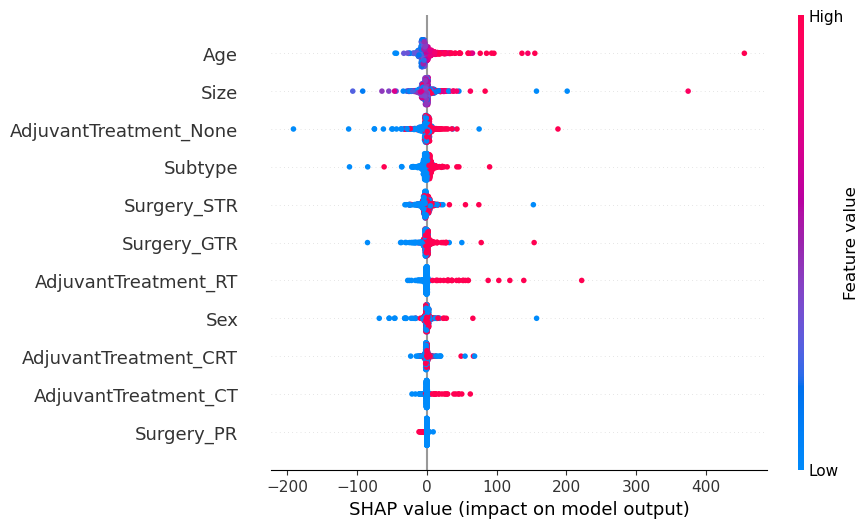

In [36]:
import matplotlib
import matplotlib.pyplot as plt
shap.plots.beeswarm(shap_values, max_display=99, show=False)
plt.gcf()
plt.savefig("beeswarm.pdf", format='pdf', bbox_inches='tight')

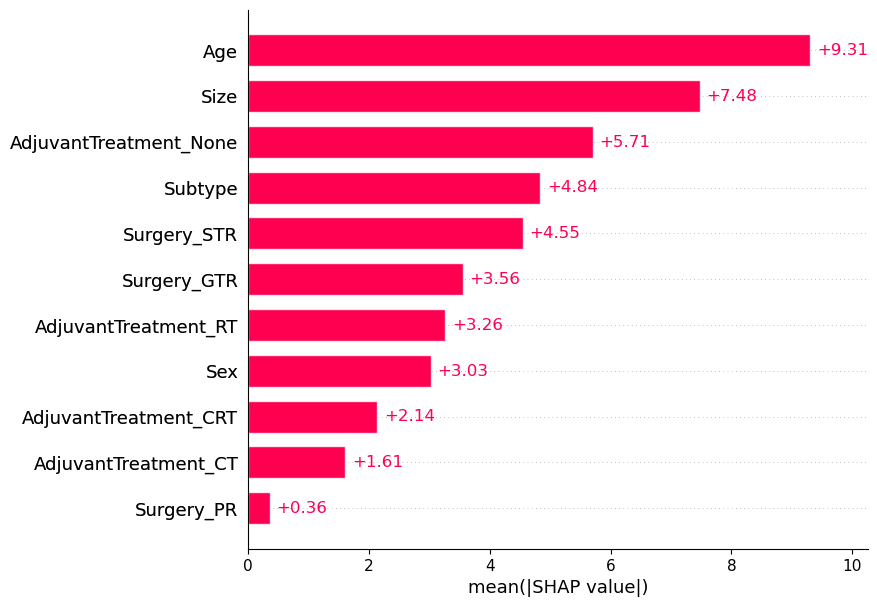

In [37]:
shap.plots.bar(shap_values, max_display=99, show=False)
plt.gcf()
plt.savefig("bar.pdf", format='pdf', bbox_inches='tight')

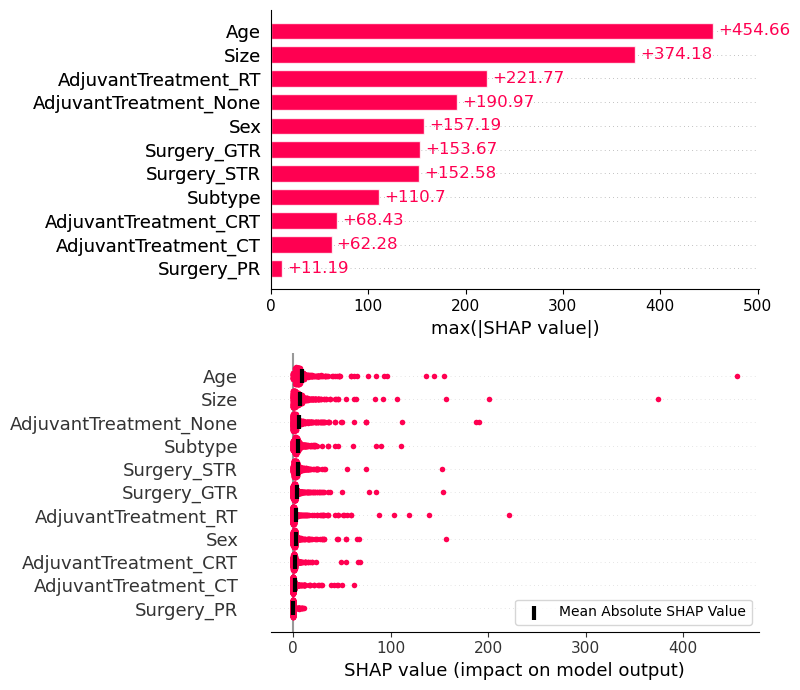

In [38]:
plt.subplot(2, 1, 1)
plt.gcf()
shap.plots.bar(shap_values.abs.max(0), max_display=99, show=False)
plt.subplot(2, 1, 2)
shap.plots.beeswarm(
    shap_values.abs, color="shap_red", max_display=99, show=False, plot_size=None
)
ax = plt.gca()
masv = {}
for feature in ax.get_yticklabels():
    name = feature.get_text()
    col_ind = td['x'].columns.get_loc(name)
    mean_abs_sv = np.mean(np.abs(shap_values.values[:, col_ind]))
    masv[name] = mean_abs_sv
ax.scatter(
    masv.values(),
    [i for i in range(len(td['x'].columns))],
    zorder=99,
    label="Mean Absolute SHAP Value",
    c="k",
    marker="|",
    linewidths=3,
    s=100,
)
ax.legend(frameon=True)
plt.tight_layout()
plt.savefig("bar_beeswarm.pdf", format='pdf', bbox_inches='tight')

In [39]:
feature_importance = np.mean(np.abs(shap_values.values), axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': td['x'].columns,  
    'Importance': feature_importance  
}).sort_values(by='Importance', ascending=False)  

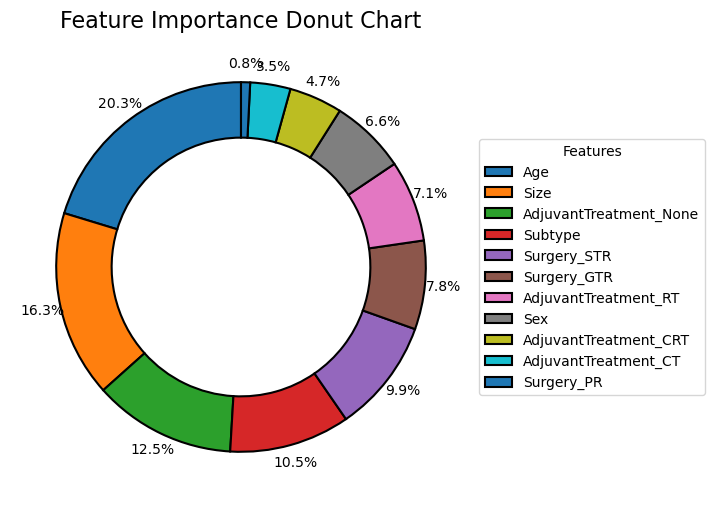

In [40]:
features = feature_importance_df['Feature']
importances = feature_importance_df['Importance']

fig, ax = plt.subplots(figsize=(8, 6))

wedges, texts = ax.pie(
    importances,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='black', linewidth=1.5),  
    labels=None  
)

for wedge, importance in zip(wedges, importances):
    angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1  
    x = 1.1 * wedge.r * np.cos(np.radians(angle)) 
    y = 1.1 * wedge.r * np.sin(np.radians(angle)) 
    ax.text(x, y, f'{importance / sum(importances):.1%}', ha='center', va='center', fontsize=10)

#ax.text(0, 0, 'Feature Importance Distribution', ha='center', va='center', fontsize=25)

ax.legend(
    wedges, features,
    title="Features",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  
    fontsize=10
)

ax.set_aspect('equal') 
plt.title('Feature Importance Donut Chart', fontsize=16)
plt.savefig("Shap_pie_plot.pdf", format='pdf', bbox_inches='tight')
plt.show()

FixedFormatter should only be used together with FixedLocator


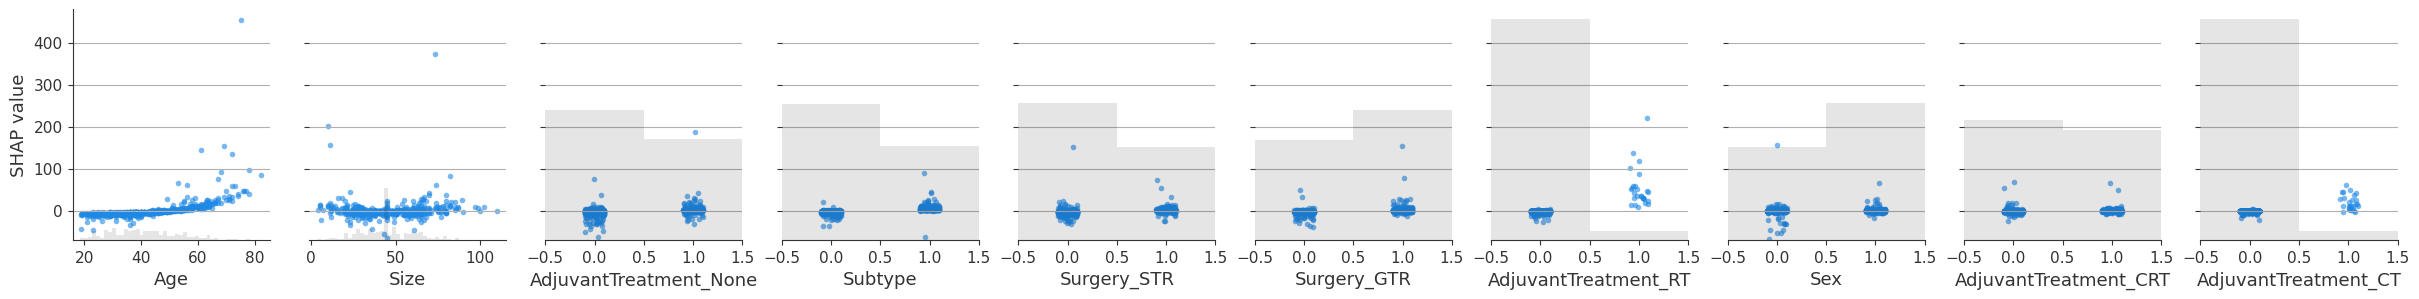

In [52]:
n = 10
fig, ax = plt.subplots(1, n, figsize=(30, 3))

for i, (k, v) in enumerate(sorted(masv.items(), key=lambda x: x[1], reverse=True)):
    if i < n:
        shap.plots.scatter(shap_values[:, k], ax=ax[i], show=False, alpha=0.6)
        ax[i].grid(axis="y")
        if i != 0:
            ax[i].set_ylabel("")
            ax[i].spines["left"].set_visible(False)
            ax[i].set_ylim(ax[0].get_ylim())
            ax[i].set_yticklabels(["" for _ in range(len(ax[0].get_yticks()))])
        else:
            ax[i].set_ylabel("SHAP value")
fig.savefig("scatter_shap.pdf", format='pdf', bbox_inches='tight')

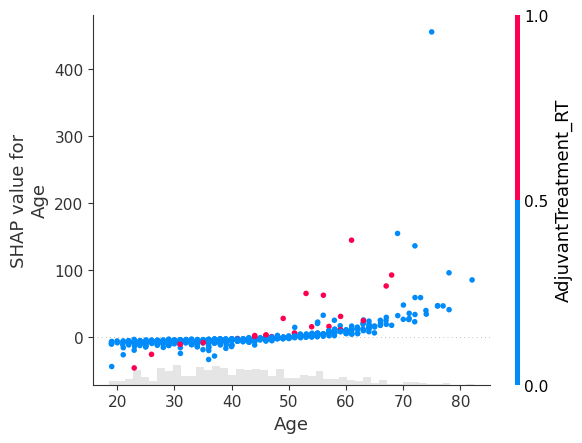

In [51]:
fig, ax = plt.subplots()
shap.plots.scatter(shap_values[:, "Age"], color=shap_values, ax=ax)
fig.savefig("/home/pengfeixu/jupyter_home/scatter_coloured.pdf", format='pdf', bbox_inches='tight')

In [43]:
from typing import Dict, List, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pysurvival.utils.metrics import concordance_index

def permutation_importance(
    model: object,
    X: pd.DataFrame,
    T: pd.Series,
    E: pd.Series,
    n_repeats: int = 100,
    random_state: int = 666
) -> Dict[str, np.ndarray]:
    
    np.random.seed(random_state)
    
    baseline_score = concordance_index(model, X, T, E)
    
    importances = {
        'feature_names': [],
        'importance_mean': [],
        'importance_std': [],
        'all_importances': []
    }
    
    for feature in tqdm(X.columns, desc="Computing feature importance"):
        feature_importance = []
        
        for _ in range(n_repeats):
            X_permuted = X.copy()
            X_permuted[feature] = np.random.permutation(X_permuted[feature].values)
            
            permuted_score = concordance_index(model, X_permuted, T, E)
            
            importance = baseline_score - permuted_score
            feature_importance.append(importance)
        
        importances['feature_names'].append(feature)
        importances['importance_mean'].append(np.mean(feature_importance))
        importances['importance_std'].append(np.std(feature_importance))
        importances['all_importances'].append(feature_importance)
    
    return importances
    
def plot_permutation_importance_boxplot_cp(
    importances_dict: Dict,
    figsize: Tuple[int, int] = (10, 6),
    box_color: str = "#3498db",
    median_color: str = "#e74c3c",
    whisker_color: str = "#2c3e50",
    outlier_color: str = "#95a5a6",
    show_points: bool = True,
    point_alpha: float = 0.3,
    title: str = "Permutation Importance Distribution"
) -> None:
  
    feature_names = importances_dict['feature_names']
    all_importances = importances_dict['all_importances']
    
    mean_importances = [np.mean(imp) for imp in all_importances]
    
    sorted_indices = np.argsort(mean_importances)
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importances = [all_importances[i] for i in sorted_indices]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    bp = ax.boxplot(
        sorted_importances,
        vert=False,  
        patch_artist=True,  
        medianprops=dict(color=median_color, linewidth=1.5),  
        flierprops=dict(
            marker='o',
            markerfacecolor=outlier_color,
            markersize=4,
            alpha=0.5,
            markeredgecolor='none'
        ),  
        whiskerprops=dict(color=whisker_color),  
        capprops=dict(color=whisker_color),  
        boxprops=dict(
            facecolor=box_color,
            alpha=0.7,
            edgecolor=whisker_color
        ) 
    )
    
    if show_points:
        for i, imp in enumerate(sorted_importances, 1):
            y_jitter = np.random.normal(i, 0.04, size=len(imp))
            ax.scatter(
                imp,
                y_jitter,
                alpha=point_alpha,
                color=box_color,
                s=20,
                zorder=1
            )
    
    ax.set_yticklabels(sorted_features)
    
    ax.set_title(title, pad=20, fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature Importance', fontsize=10)
    
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, zorder=0)
    
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.grid(False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    return fig, ax


Computing feature importance: 100%|██████████| 11/11 [01:05<00:00,  5.98s/it]


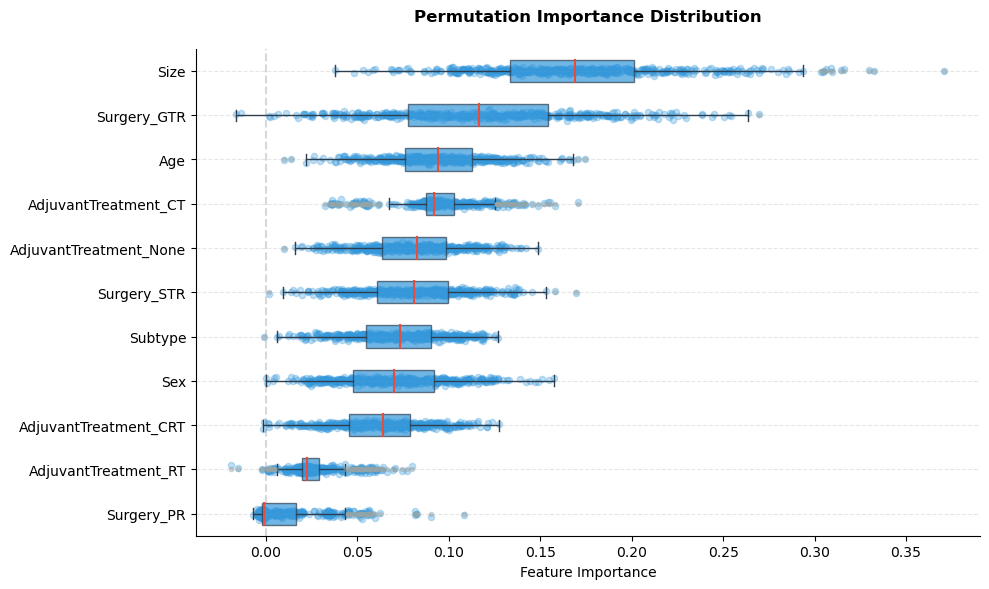

In [44]:
importances = permutation_importance(model=nncph,X=td['x'],T=td['t'],E=td['e'],n_repeats=500)

fig, ax = plot_permutation_importance_boxplot_cp(importances)

fig.savefig("permutation_importance.pdf", format='pdf', bbox_inches='tight')